In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
%matplotlib inline
from astropy.io import fits

In [2]:
star = 'GL699'
data = fits.open('ADP.GL2021-11-04T16:26:19.423.fits')
data.info()
image_data = data[0].data # Get the data associated with the HDU, same as for a table
print(data[1].columns)
evt_data = Table(data[1].data)            
print(evt_data)
print(evt_data['WAVE'].data)

Filename: ADP.GL2021-11-04T16:26:19.423.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1701   ()      
  1  SPECTRUM      1 BinTableHDU     86   1R x 12C   [443262D, 443262D, 443262D, 443262J, 443262D, 443262D, 443262D, 443262D, 443262J, 443262D, 443262D, 443262J]   
ColDefs(
    name = 'WAVE'; format = '443262D'; unit = 'angstrom'
    name = 'FLUX'; format = '443262D'; unit = 'erg.cm**(-2).s**(-1).angstrom**(-1)'
    name = 'ERR'; format = '443262D'; unit = 'erg.cm**(-2).s**(-1).angstrom**(-1)'
    name = 'QUAL'; format = '443262J'
    name = 'SNR'; format = '443262D'
    name = 'WAVE_AIR'; format = '443262D'; unit = 'angstrom'
    name = 'FLUX_EL'; format = '443262D'
    name = 'ERR_EL'; format = '443262D'
    name = 'QUAL_EL'; format = '443262J'
    name = 'FLUX_CAL'; format = '443262D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
    name = 'ERR_CAL'; format = '443262D'; unit = 'erg.s**(-1).cm**(-2).angstrom**(-1)'
    name = 

Text(0, 0.5, 'Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')

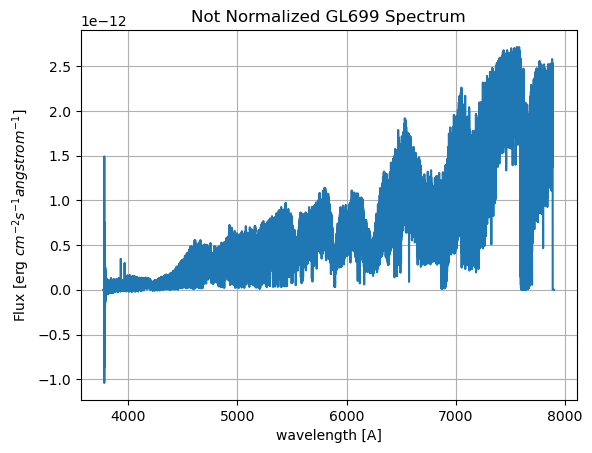

In [3]:
#This is for all of data plotted, not normalized
plt.title('Not Normalized GL699 Spectrum')

plt.plot(evt_data['WAVE'][0][:],evt_data['FLUX'][0][:])
plt.grid()

plt.xlabel('wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')

Text(0.5, 1.0, 'Not Normolized Sodium D Spectral Lines ')

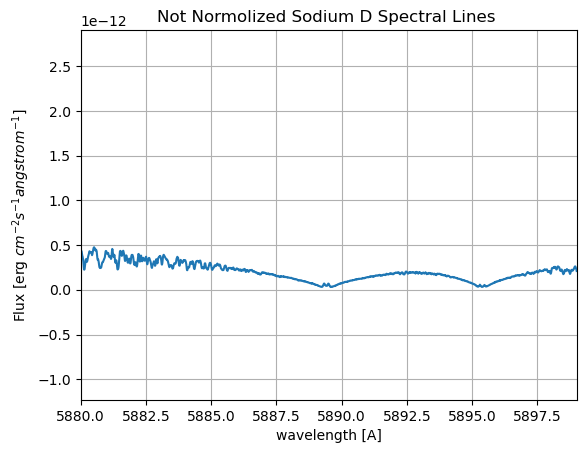

In [4]:
#This is the same as above, but "zooming in" on wavelength to get a look at Na D spectral lines (not normalized)
plt.plot(evt_data['WAVE'][0][:],evt_data['FLUX'][0][:])
plt.xlim(5880,5899) #the wavelengths we expect to see the Na D spectral lines 
plt.grid()
plt.xlabel('wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Not Normolized Sodium D Spectral Lines ')

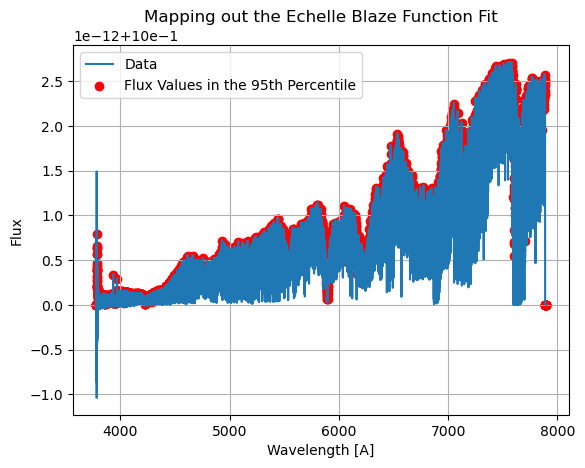

In [12]:
#This is for all data 
#dividing the data into 100 pixels
#finding the flux value in 95th percentile within each bin
#plotting the above flux values onto wavelength values
#dividing tauceti flux specctrum by the fit of 95th percentile flux values
#still NOT normalized

#try different bin size like 50
bin = 50
wave = evt_data['WAVE'][0][:]
flux = evt_data['FLUX'][0][:] + 1
# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wave) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wave[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wave, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'red', label = 'Flux Values in the 95th Percentile')
# plt.xlim(5880,5899)
# plt.plot(wave, flux_fit, label ='blaze func')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.grid()
plt.legend()
plt.show()

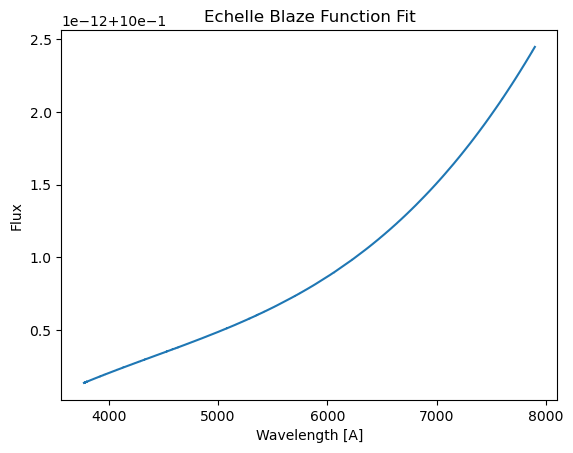

In [13]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl_values, spl)
plt.plot(wl_values, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

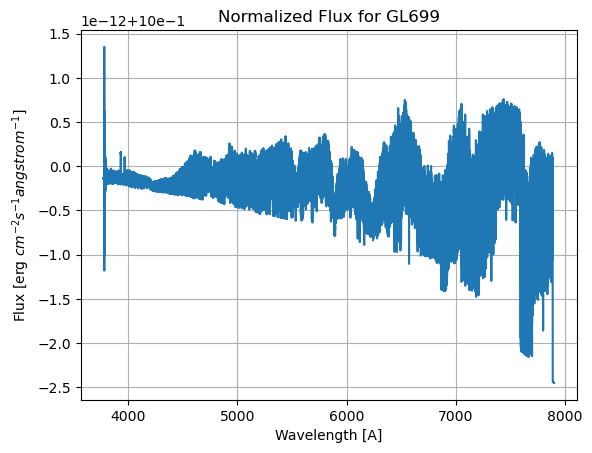

In [19]:
#for all data
#dividing the fit from data
#this is normalizing all of the data
first_normalized_flux = flux  / flux_fit # + 1
plt.plot(wave, first_normalized_flux ) #* 1e12)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Normalized Flux for GL699')
plt.grid()
plt.show()

# Stopping here, need to make sure if this is correct before proceeding with the rest

In [ ]:
#Constant Radial Velocity Space
#plotting the normalized flux values onto the original wavelength grid
#creating a new wavelength grid that is log lambda spaced 
#then interpolate onto the new wavelength grid
#will create a spectrum that is in constant RV space
#it will allow for a straightforward calculation of the Doppler shift

#I'm not sure if this is correct
flux98 = np.percentile(first_normalized_flux, 98)
normalized_flux = first_normalized_flux 
f = scipy.interpolate.interp1d(wave, normalized_flux, kind='cubic')

#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s
C = 299792.458 #km/s
wl_start = min(wave) + 0.2
wl_end = max(wave) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux = f(wl)

#plotting new wavelength grid against flux values
#should look like as before, but this time wavelengths should be velocity spaced instead
plt.plot(wl, flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
plt.show()

# NSO Solar Spectrum

In [ ]:
#reading NSO data file
#downloaded the NSO fits file from the tutorial github
#I googled and it seems like we can "compare" stars spectrum with our own sun when it comes to spectrum analysis
solardata = fits.open('nso.fits')
solardata.info()
image_data = solardata[0].data # Get the data associated with the HDU, same as for a table
wl_temp = solardata[0].data
fl_temp = solardata[1].data
print(wl_temp)
print(fl_temp)

#trying to truncate the solar spectrum to match the wavelength range of tauceti data
#plotting all of the data
min_wl = min(wl) - 8
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

max_wl = max(wl) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index]
fl_syn_temp = fl_temp[min_index:max_index]

plt.plot(wl_syn_temp, fl_syn_temp)
# plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

#zooming in to see for the sodium d lines
plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

In [ ]:
#regrid "synthetic" spectrum to be log lambda spaced (contant velocity).
#then plot the new wavelength grid against flux values (just like before) 
#should look the same as before
#the wavelengths are now velocity spaced (same as we did for tauceti spectrum) 
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)


plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

#showing it for sodium d line
plt.xlim(5880,5899)
plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

In [ ]:
#Finding the current offset of tauceti spectrum and the empirical spectrum
min_wl = min(wl)
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
index = wl_syn.tolist().index(w)
print('The first value of the data is located at pixel ' + str(index) + ' of the empirical spectrum.')

#need to do a chi-squared test to figure out the offset of the data and the empirical spectrum
#chi-squared test scans the data against the synthetic spectrum 
#begins where the first pixels of each spectrum line up and end where the last pixels of each spectrum line up.
#chi squared also calculates the residual at each location. 
#when the two spectra line up, the residual will be minimized, resulting in a minimum in the chi-squared plot.
#defining the chi function
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl)):
    syn_flux = fl_syn[i: i + len(wl)]
    chi_squared = chi(syn_flux, flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The GL699 spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The GL699 spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

plt.plot(indices - index, chi_squared_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test')
plt.show()

In [ ]:
#plotting residuals
residuals_unshifted = flux[len(wl_syn)] - fl_syn_plot
plt.xlim(5880,5899)
plt.plot(wl_syn, residuals_unshifted)
 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Residuals of Shifted tauceti Spectrum against Empirical Spectrum')

plt.show()

print('The average residual is ' + str(np.average(residuals_unshifted)))

In [ ]:
#plot of the shifted spectrum against the empirical spectrum
#it should line up with the empirical spectrum much better

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

plt.plot(shifted_wl, shifted_fl)
# plt.xlim(5880,5899)
plt.title('Final Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
# plt.xlim(3780,3790)
# plt.xlim(3800,3804)
plt.show()